Start with our usual setup, including the utility methods from last time.

In [433]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math

# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def display(img, title=None):
    # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def timing(f):
    # Timing decorator
    def out(*args, **kwargs):
        time1 = time()
        output = f(*args, **kwargs)
        time2 = time()
        
        print('{} function took {} seconds'.format(f.__name__, round(time2-time1, 5)))
        return output
    return out

First, we're going to explore the Gaussian kernel. You may need to run `pip3 install opencv-python` and restart Jupyter notebook.

In [394]:
import cv2
filter = cv2.getGaussianKernel(5, 1)
filter

array([[0.05448868],
       [0.24420134],
       [0.40261995],
       [0.24420134],
       [0.05448868]])

As we might expect, this returns a 1x5 Gaussian kernel, where the standard deviation is 1. We can use two of these kernels to create a 2d filter, or we can use the higher level function GaussianBlur. Let's try that next. We'll compare the output of the Gaussian blur filter to the simple moving average blur filter we learned about earlier.

Base image:


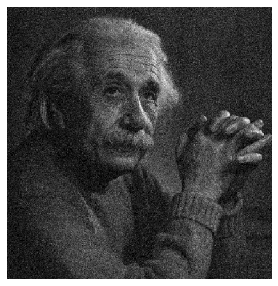

Gaussian, kernel size=(5,5), sigma=default:


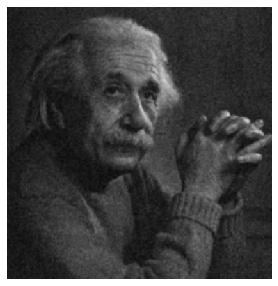

Gaussian, kernel size=(51,51), sigma=default:


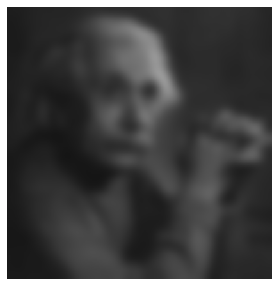

Gaussian, kernel size=(51,51), sigma=2:


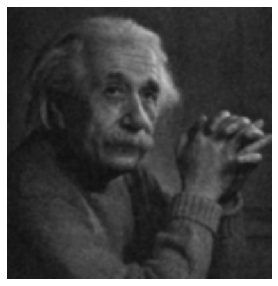

Average, kernel size=(5,5):


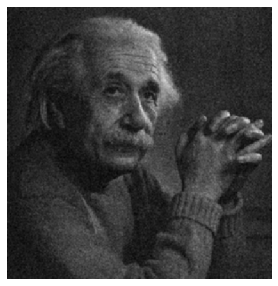

In [395]:
image = cv2.imread('./noisy_einstein.png')
print('Base image:')
display(image)

blur_image_1 = cv2.GaussianBlur(image, (5,5), 0)
print('Gaussian, kernel size=(5,5), sigma=default:')
display(blur_image_1)

blur_image_2 = cv2.GaussianBlur(image, (51,51), 0)
print('Gaussian, kernel size=(51,51), sigma=default:')
display(blur_image_2)

blur_image_3 = cv2.GaussianBlur(image, (51,51), 2)
print('Gaussian, kernel size=(51,51), sigma=2:')
display(blur_image_3)

simple_blur_filter = np.array(
[
    [.11,.11,.11],
    [.11,.11,.11],
    [.11,.11,.11],
])
simple_blur_image = cv2.filter2D(image, -1, simple_blur_filter)
print('Average, kernel size=(5,5):')
display(simple_blur_image)

# Exercise 1

Recall from lecture that the two parameters to Gaussian blur are kernel size and sigma. How do changing these parameters affect the output of the blur filter? You may want to find a different example image to illustrate your point.

Next, let's look at the thresholding parameters.

Base Image


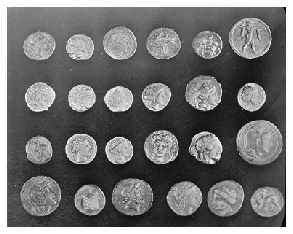

Edge detection, low=0 high=0:


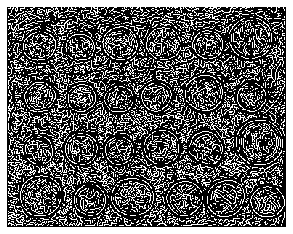

Edge detection, low=0 high=20:


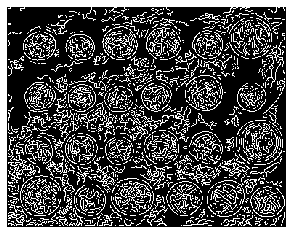

Edge detection, low=0 high=40:


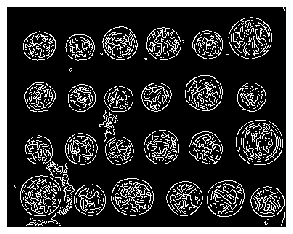

Edge detection, low=0 high=60:


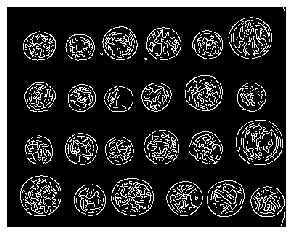

Edge detection, low=20 high=0:


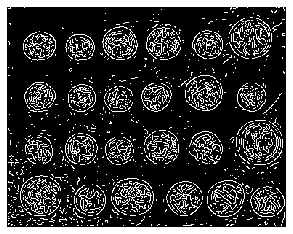

Edge detection, low=20 high=20:


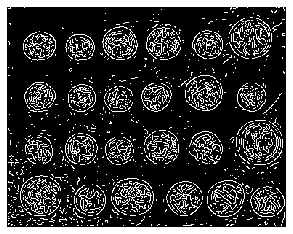

Edge detection, low=20 high=40:


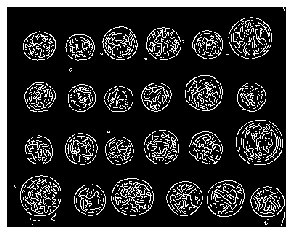

Edge detection, low=20 high=60:


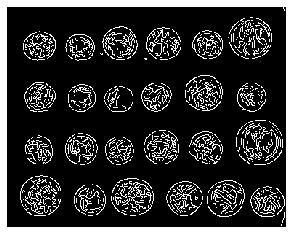

Edge detection, low=40 high=0:


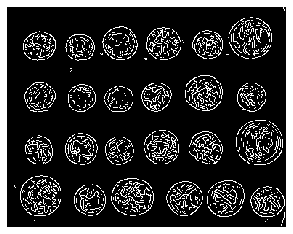

Edge detection, low=40 high=20:


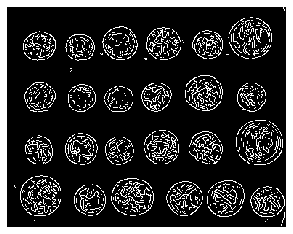

Edge detection, low=40 high=40:


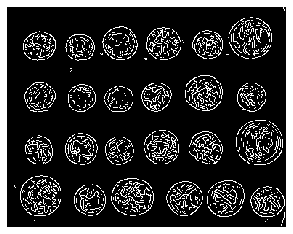

Edge detection, low=40 high=60:


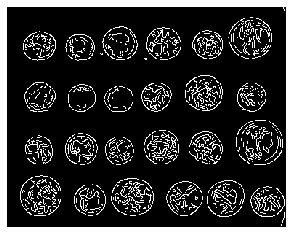

Edge detection, low=60 high=0:


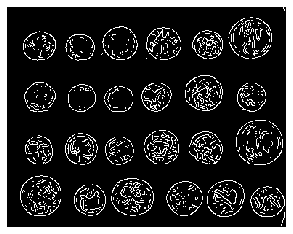

Edge detection, low=60 high=20:


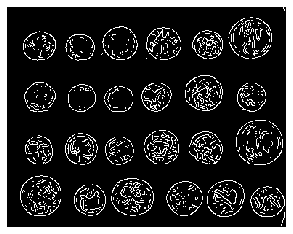

Edge detection, low=60 high=40:


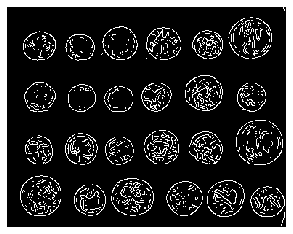

Edge detection, low=60 high=60:


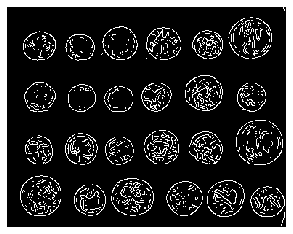

In [396]:
from skimage import feature, data

image = data.coins()

print('Base Image')
display(image)

# Various low and high thresholds
low_thresholds = [0, 20, 40, 60]
high_thresholds = [0, 20, 40, 60]

for low in low_thresholds:
    for high in high_thresholds:
        # Iterate over possible combinations of thresholds and display results
        print(f'Edge detection, low={low} high={high}:')
        
        edge_image = feature.canny(image, sigma=1, low_threshold=low, high_threshold=high)
        display(edge_image)


# Exercise 2

1. Play with the thresholds to get different output. How does changing each threshold affect the edges that the algorithm finds?
2. Imagine that you have an image with lots of false positives: that is, it finds lots of edges that aren't actually edges. How would you adjust thresholds to improve the result?
3. Imagine that you have an image where the edges don't connect well: that is, it finds some edges, but the edges tend to be broken lines instead of solid lines. How would you adjust thresholds to improve the result?
5. Remember from exercise 1 that the two parameters to the Gaussian blur are kernel size and sigma, and that both affect the output of the blur filter. Notice that skimage's canny implementation only takes sigma as a parameter. Without modifying the source code, how might you incorporate a different kernel size into the implementation?
4. Try to improve the edges you find by tweaking the parameters. 
5. Try running the edge detector on some different images. skimage.data has a good set to start with. You can also look at [Berkeley's collection of benchmark images](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/). Take notes on which images Canny performs well on, and which it does not.




1. Increasing the low threshold seems to cut out larger portions of the image, including both noise and detail. Increasing the high theshold seems to do less; when the low threshold is moderate, the high threshold just seems to cut out detail as it increases. However, when the low threshold was very low the high threshold also seemed to cut out a lot of noise. This makes sense more or less, as when the low threshold is properly set, increasing the high threshold will just reduce the number of strong edges.
2. As demonstrated by the diference between the `low = 0` images and other ones, increasing the low threshold seems to be very good for getting rid of noise.
3. Looking at the `low = 40` cases and comparring the `high = 0` and `high = 60` cases, it seems that lowering the high theshold helps ensure edges connect properly, as it increases the number of storng edges.
4. One way a higher effective kernel size could be implemented would be to first pass the image through a Gaussian blur of any desired kernel size and sigma before passing the image to the Canny edge detection. Then, in order to avoid applying two Gaussian blurs, the Canny function would be passed a very small—but not 0—value of sigma so that its Gaussian blur is approximately the identity kernel (if 0 is passed, the function automatically chooses a better value). 
5. Looking at the images already generated, the `low = 20` `high = 60` case seems to have a good combination of noise suppression and edge connectivity. Varying `sigma` was actually not too productive; `sigma = 1` was one of the better options from the ones I tested.

# Hough Transform

In this exercise, we'll explore how edge detection and line-finding can be used to implement part of a self-driving car algorithm.

We'll start with the steps we covered in lecture: find the edges and then find the lines.

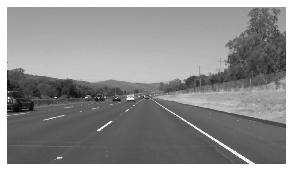

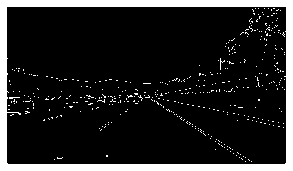

In [397]:
image = cv2.imread('./road.jpg', flags=cv2.IMREAD_GRAYSCALE)

display(image)

# Canny edge detection with thresholds
edge_image = feature.canny(image, sigma=1, low_threshold=60, high_threshold=70)
display(edge_image)

We'll use the probabilistic hough transform function, as it's a bit easier to work with.

In [398]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edge_image, threshold=1, line_length=40,
                                 line_gap=1)

# Only keep lines that have both endpoints in lower half of image
half_height = image.shape[0]/2
lower_lines = [line for line in lines if line[0][1] > half_height and line[1][1] > half_height]

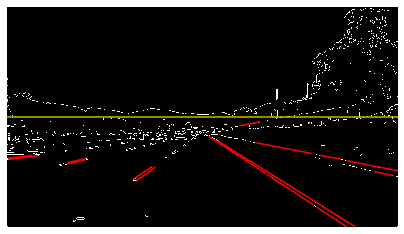

In [399]:
plt.figure(figsize=(7,7))
plt.imshow(edge_image)
plt.axis('off')

# Indicate where image half height is
plt.axline((0, half_height), slope=0, c='y')

# Plot edge segments
for line in lower_lines:
    plt.plot(*zip(*line), c='red')
    
plt.show()

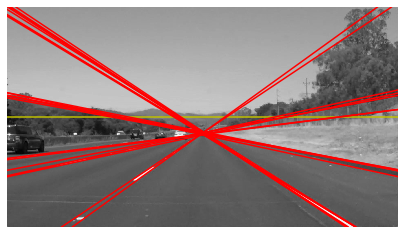

In [400]:
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.axis('off')

# Indicate where image half height is
plt.axline((0, half_height), slope=0, c='y')

# Plot infinite lines using axline
for line in lower_lines:
    plt.axline(*line, c='red')
    
plt.show()

# Exercise 3

1. We've found some lines. Lots of them, in fact. Using only the techniques we've learned so far, how can we clean up this image to only show the lines that correspond to lanes? Optional: implement some of them and show the improvement in the produced image.

2. We can also use additional information that we have about the image; namely, we know that our images are always coming from a camera mounted on the front of the car. How could we use this information to improve on our lane-finding algorithm? Optional: implement your suggestion and show the improvement in the produced image.

3. A video is just a series of images (usually 30 images per second). Imagine that your lane-finding algorithm is being fed a video from a front-mounted camera. Describe how you would use your lane-finding algorithm to keep the car driving straight and in its lane.

1. By setting the various tolerences (in both the Canny part and the Hough transform) rather high, we manage to extract just some lines for the lanes. Extending these lines would give you the lane lines.

2. Since we know that, on straight road at least, lane lines are straight lines that extend infinitely to the horizon, we can extend all of the edges we find to infinite lines, and treat their entire extent as a marker for the lanes.

3. One way to do this would be to look at intersections of the edges with the bottom edge of the image; this would provide some number of points. We could then take the points closest on the left and right to the x center of the image, and try to drive so that the x center is exactly halfway between these two points. The intution for this is that the left and right closest points indicate the lane edges on each side of us, so we should try and keep the x center of the image (which corresponds to the center line of the car) halfway between the two edges.

# Canny Implementation

In [401]:
def angle_sector(x, y):
    """
        Args:
            x: float
            y: float
        Returns:
            sector int

        This function takes an (x,y) position, and returns 0, 1, 2, 3 depending on the
        angle of the point (0 for horizontal, 1 for diagonal up, 2 for vertical, 3 for
        diagonal down)
    """
    angle = 4*np.arctan2(y, x)/math.pi +1/2
    
    sector = np.floor(angle % 4)
    
    return sector

def non_max(mid, side1, side2):
    """
        Args:
            mid: float
            side1: float
            side2: float
        Returns:
            mid: float

        Returns mid if it is bigger than side1 and side2.
    """
    if mid >= side1 and mid >= side2:
        return mid
    
    return 0
    
def high_mask(highs):
    """
        Args:
            highs: boolean array
        Returns:
            result: boolean array of same size

        Returns a boolean array with a True value for every position that is touching
        (8-connectivity) a True value in highs.

        This is done by adding various shifts of highs to itself.
    """
    result = highs.copy()
    
    # Get left-right connectivity by adding horizontal shifts
    result += np.pad(highs[1:,:], ((0,1), (0,0)))
    result += np.pad(highs[:-1,:], ((1,0), (0,0)))
    
    # Get all other directions by adding up-down vertical shifts
    # Which include the added left-right shifts
    result += np.pad(result[:,1:], ((0,0), (0,1)))
    result += np.pad(result[:,:-1], ((0,0), (1,0)))
    
    return result > 0

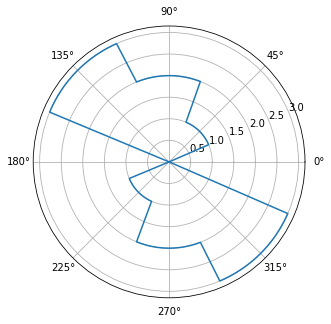

In [402]:
t = np.linspace(0, 2*math.pi, 200)
x, y = np.cos(t), np.sin(t)

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(projection='polar')

plt.plot(t, angle_sector(x,y))

plt.show()

This is just meant to show exactly what `angle_sector` is doing.

In [403]:
def bi_directional_edge_finder(image):
    """
        Args: 
            image: numpy array
        Returns:
            h_result: numpy array of same size
            v_result: numpy array of same size
            
        bi_directional_edge_finder is the first step in the Canny
        algorith. It passes a blur filter over the image, and returns
        both horizontal and vertical Sobel edge detection.
    """
     
    h_filter = np.array([
                        [1, 0, -1],
                        [2, 0 ,-2],
                        [1, 0, -1]])  
    v_filter = - np.array([
                        [1, 2, 1],
                        [0, 0 ,0],
                        [-1, -2, -1]])
    
    # Blur image with Gaussian kernel
    blur_image = cv2.GaussianBlur(image, (5,5), 0)
    
    # Pass filter over image
    h_result = cv2.filter2D(blur_image, ddepth=cv2.CV_16S, kernel=h_filter, )
    v_result = cv2.filter2D(blur_image, ddepth=cv2.CV_16S, kernel=v_filter,)
    
    return np.array(h_result, dtype='float64'), np.array(v_result, dtype='float64')

In [448]:
def non_maximum_suppression(image):
    """
        Args: 
            image: numpy array (dim 2)
        Returns:
            result: numpy array of same size as image

        Takes the horizontal and vertical derivatives, and performs
        non-maximum suppression on the magnitudes.
    """
    # Get horizontal and vertical derivatives
    h_filtered, v_filtered = bi_directional_edge_finder(image)
    
    # Get squared magnitude of all derivatives
    mags = h_filtered**2 + v_filtered**2
    
    # Create blank output array
    image_shape = image.shape
    result = np.zeros(image_shape)
    
    # Offsets that will be used
    sector_offsets = {0: (0, 1), 1: (1, -1), 2: (1, 0), 3: (1, 1)}
    
    # Iterate over image excluding border pixels 
    for row in range(1, image_shape[0]-1):
        for column in range(1, image_shape[1]-1):
            # Get current h/v derivavtives
            h_val = h_filtered[row, column]
            v_val = v_filtered[row, column]
            
            # Get current magnitude
            mag = mags[row, column]
            
            # Get angle sector based on h/v derivatives
            sector = angle_sector(h_val, v_val)
            
            # Get offset based on sector
            offset = sector_offsets[sector]
            
            # Find adjacent magnitudes based on offset
            side1 = mags[row - offset[0], column - offset[1]]
            side2 = mags[row + offset[0], column + offset[1]]
            
            # Perform non-maximum suppression
            result[row, column] = non_max(mag, side1, side2)
            
    return result

In [449]:
@timing
def Canny(image, low_threshold, high_threshold):
    """
        Args: 
            image: numpy array (dim 2)
            low_threshold: float
            high_threshold: float
        Returns:
            result: boolean array of same size as image
            
        Performs Canny edge detection with low and high thresholds.
        Values below low_threshold are suppressed, while remaining
        values must be adjacent to a value above high_theshold.
    """
    # Perform non-maximum suppression
    max_suppress = non_maximum_suppression(image)
    
    # Square thresholds as magnitudes were left squared
    low_threshold = low_threshold**2
    high_threshold = high_threshold**2
    
    # Remove all values below low_threshold
    low_thresh = np.where(max_suppress < low_threshold, 0, max_suppress)
    
    # Get strong edges
    highs = low_thresh >= high_threshold
    
    # Get connectivity mask from strong edges
    mask = high_mask(highs)
    
    # Only include edges touching a strong edge, and convert to boolean
    result = low_thresh * mask > 0
    
    return result

Canny function took 3.39064 seconds


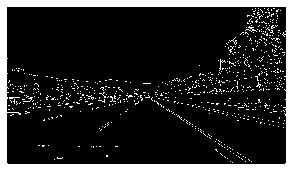

In [452]:
display(Canny(image, 20, 40))

canny function took 0.161 seconds


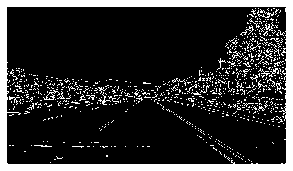

In [451]:
display(timing(feature.canny)(image, sigma = 0, low_threshold=20, high_threshold=40))

My implementation of Canny edge detection does not work as well as the standard implementation (unsurprisingly). It is about 20 times slower and also seems to be loosing detail as compared to the standard version. However, it still seems to work.